# Fundamentals of Deep Learning 

*Notebook 2.3: Practice with Backpropagation*

This code example implements back-propagation algorithm for a two-level network and demonstrates how to use it to learn the exclusive OR (XOR) function. The network has two neurons in the hidden layer and a single output neuron. The noebook is based on the example from Learning Deep Learning by Magnus Ekman.

In [ ]:
"""
The MIT License (MIT)
Copyright (c) 2021 NVIDIA
Permission is hereby granted, free of charge, to any person obtaining a copy of
this software and associated documentation files (the "Software"), to deal in
the Software without restriction, including without limitation the rights to
use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
the Software, and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:
The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
"""


## Before we start ...

In [16]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [17]:
def sigmoidDerivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

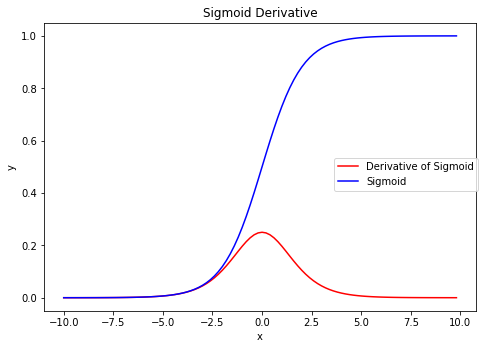

In [20]:
from matplotlib import pyplot as plt
x = np.arange(-10, 10, 0.2)
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
y = sigmoidDerivative(x)
ax.plot(x, y, color="red", label='Derivative of Sigmoid'.format(1))
y = sigmoid(x)
ax.plot(x, y, color="blue", label='Sigmoid'.format(1))
fig.legend(loc='center right')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Sigmoid Derivative")
print()

## Backpropagatin

Initialize the dataset.  The training examples assume that the ground truth to be between 0.0 and 1.0 as we are using the logistic sigmoid function as an activation function for the output neuron.


In [9]:
import numpy as np

np.random.seed(3) # To make repeatable
LEARNING_RATE = 0.1
index_list = [0, 1, 2, 3] # Used to randomize order

# Define training examples.
x_train = [np.array([1.0, -1.0, -1.0]),
           np.array([1.0, -1.0, 1.0]),
           np.array([1.0, 1.0, -1.0]),
           np.array([1.0, 1.0, 1.0])]
y_train = [0.0, 1.0, 1.0, 0.0] # Output (ground truth)

In the next code snippet, we declare variables to hold the state of our three neurons. A real implementation would typically be parameterized to be able to choose number of inputs, layers, and number of neurons in each layer, but all of those parameters are hardcoded in this example to focus on readability.


In [10]:
def neuron_w(input_count):
    weights = np.zeros(input_count+1)
    for i in range(1, (input_count+1)):
        weights[i] = np.random.uniform(-1.0, 1.0)
    return weights

n_w = [neuron_w(2), neuron_w(2), neuron_w(2)]
n_y = [0, 0, 0]
n_error = [0, 0, 0]


The next code snippet starts with a function to print all the nine weights of the network (each print statement prints a three-element weight vector). The forward_pass function first computes the outputs of neurons 0 and 1 with the same inputs (the inputs from the training example) and then puts their outputs into an array, together with a bias value of 1.0, to use as input to neuron 2. That is, this function defines the topology of the network. We use tanh for the neurons in the first layer and the logistic sigmoid function for the output neuron.

The backward_pass function starts by computing the derivative of the error function and then computes the derivative of the activation function for the output neuron. The error term of the output neuron is computed by multiplying these two together. We then continue to backpropagate the error to each of the two neurons in the hidden layer. This is done by computing the derivatives of their activation functions and multiplying these derivatives by the error term from the output neuron and by the weight to the output neuron.

Finally, the adjust_weights function adjusts the weights for each of the three neurons. The adjustment factor is computed by multiplying the input by the learning rate and the error term for the neuron in question.


In [11]:
def show_learning():
    print('Current weights:')
    for i, w in enumerate(n_w):
        print('neuron ', i, ': w0 =', '%5.2f' % w[0],
              ', w1 =', '%5.2f' % w[1], ', w2 =',
              '%5.2f' % w[2])
    print('----------------')

def forward_pass(x):
    global n_y
    n_y[0] = np.tanh(np.dot(n_w[0], x)) # Neuron 0
    n_y[1] = np.tanh(np.dot(n_w[1], x)) # Neuron 1
    n2_inputs = np.array([1.0, n_y[0], n_y[1]]) # 1.0 is bias
    z2 = np.dot(n_w[2], n2_inputs)
    n_y[2] = 1.0 / (1.0 + np.exp(-z2))

def backward_pass(y_truth):
    global n_error
    error_prime = -(y_truth - n_y[2]) # Derivative of loss-func
    derivative = n_y[2] * (1.0 - n_y[2]) # Logistic derivative
    n_error[2] = error_prime * derivative
    derivative = 1.0 - n_y[0]**2 # tanh derivative
    n_error[0] = n_w[2][1] * n_error[2] * derivative
    derivative = 1.0 - n_y[1]**2 # tanh derivative
    n_error[1] = n_w[2][2] * n_error[2] * derivative

def adjust_weights(x):
    global n_w
    n_w[0] -= (x * LEARNING_RATE * n_error[0])
    n_w[1] -= (x * LEARNING_RATE * n_error[1])
    n2_inputs = np.array([1.0, n_y[0], n_y[1]]) # 1.0 is bias
    n_w[2] -= (n2_inputs * LEARNING_RATE * n_error[2])


With all these pieces in place, the only remaining piece is the training loop shown in the code snippet below.

We pick training examples in random order, call the functions forward_pass, backward_pass, and adjust_weights, and then print out the weights with the function show_learning. We adjust the weights regardless whether the network predicts correctly or not. Once we have looped through all four training examples, we check whether the network can predict them all correctly, and if not, we do another pass over them in random order.


In [ ]:
# Network training loop.
all_correct = False
while not all_correct: # Train until converged
    all_correct = True
    np.random.shuffle(index_list) # Randomize order
    for i in index_list: # Train on all examples
        forward_pass(x_train[i])
        backward_pass(y_train[i])
        adjust_weights(x_train[i])
        show_learning() # Show updated weights
    for i in range(len(x_train)): # Check if converged
        forward_pass(x_train[i])
        print('x1 =', '%4.1f' % x_train[i][1], ', x2 =',
              '%4.1f' % x_train[i][2], ', y =',
              '%.4f' % n_y[2])
        if(((y_train[i] < 0.5) and (n_y[2] >= 0.5))
                or ((y_train[i] >= 0.5) and (n_y[2] < 0.5))):
            all_correct = False
